In [348]:
%matplotlib inline
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from math import sqrt
import seaborn as sns
from core import *
import quandl
token='QWe8iSbyAFzRuod2aroM'

In [80]:
sp = get_sp()
rets=sp.pct_change()
df=pd.DataFrame()
df['X1']=rets
df['X2']=get_bond_time_series()
df['Y']=rets.shift(1)
df['Ybar']=df.Y/df.Y.abs()
df=df.dropna()

In [103]:
s=[]
for i in df.Y:
    s.append(1 if i>0 else 0)
df['Y2']=pd.Series(s,index=df.index)

In [269]:
x=df[['X1','X2']].values
y=df.Y.values

In [281]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,random_state=0)

In [278]:
y_train_flat= flatten(y_train)
y_test_flat = flatten(y_test)

In [279]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [295]:
d_train = lgb.Dataset(x_train, label=y_train_flat)
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 20
params['min_data'] = 50
params['max_depth'] = 20
clf = lgb.train(params, d_train, 100)

In [296]:
y_pred=clf.predict(x_test)

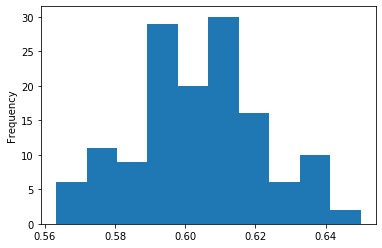

In [297]:
pd.Series(y_pred).plot(kind='hist')

In [298]:
y_pred_bar=[]
for i in range(0,y_pred.size):
    if y_pred[i]>=.6:       # setting threshold to .5
       y_pred_bar.append(1)
    else:  
       y_pred_bar.append(0)
y_pred_bar=np.array(y_pred_bar)

In [300]:
accuracy=accuracy_score(y_pred_bar,y_test_flat)
cm = confusion_matrix(y_test_flat, y_pred_bar)

In [301]:
cm

array([[26, 24],
       [30, 59]])

In [302]:
accuracy

0.6115107913669064

In [324]:
annual_ret/stds

1.182620735353893

In [328]:
y_pred_in=clf.predict(x_train)
accuracy_score(flatten(y_pred_in),flatten(y_train))

0.605072463768116

# Experiment comparing in-sample verus out of sample IR
First experiment is just to look at different slicing of the data using the same hyper parameters

In [353]:
res=[]
for i in range(0,1000):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)
    y_train_flat= flatten(y_train)
    y_test_flat = flatten(y_test)
    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    d_train = lgb.Dataset(x_train, label=y_train_flat)
    clf = lgb.train(params, d_train, 100)

    # Out of sample IR calculation
    y_pred=clf.predict(x_test)
    y_pred_bar=[]
    for i in range(0,y_pred.size):
        if y_pred[i]>=.6:       # setting threshold to .5
           y_pred_bar.append(1)
        else:  
           y_pred_bar.append(0)
    y_pred_bar=np.array(y_pred_bar)
    IR=calc_IR(y_pred_bar,y_test)

    # In sample 
    y_pred_in=clf.predict(x_train)
    in_sample=accuracy_score(flatten(y_pred_in),flatten(y_train))
    res.append([IR,in_sample])
final_res=pd.DataFrame(res,columns=['IR','In Sample'])

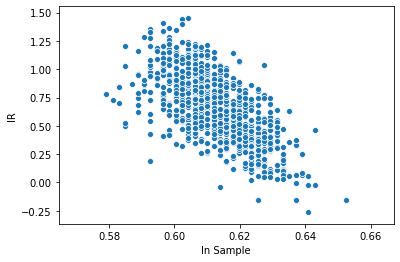

In [378]:
sns.scatterplot(y='IR',x='In Sample',data=final_res)

In [381]:
res=[]
for i in range(0,2000):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)
    y_train_flat= flatten(y_train)
    y_test_flat = flatten(y_test)
    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    d_train = lgb.Dataset(x_train, label=y_train_flat)
    params = {}
    params['learning_rate'] = np.random.random()/7
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'binary'
    params['metric'] = 'binary_logloss'
    params['sub_feature'] = 0.5
    params['num_leaves'] = np.random.randint(5,30)
    params['min_data'] = 50
    params['max_depth'] = np.random.randint(5,10)
    clf = lgb.train(params, d_train, 100)

    # Out of sample IR calculation
    y_pred=clf.predict(x_test)
    y_pred_bar=[]
    for i in range(0,y_pred.size):
        if y_pred[i]>=.6:       # setting threshold to .5
           y_pred_bar.append(1)
        else:  
           y_pred_bar.append(0)
    y_pred_bar=np.array(y_pred_bar)
    IR=calc_IR(y_pred_bar,y_test)

    # In sample 
    y_pred_in=clf.predict(x_train)
    in_sample=accuracy_score(flatten(y_pred_in),flatten(y_train))
    res.append([IR,in_sample])
final_res_hp=pd.DataFrame(res,columns=['IR','In Sample'])

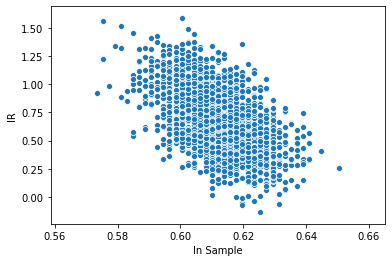

In [382]:
sns.scatterplot(y='IR',x='In Sample',data=final_res_hp)

# Additional futures market

In [385]:
mkts={'SP 500':'CHRIS/CME_SP1',
      #'US 10Y':'CHRIS/CME_TY1',
      'Crude Oil':'CHRIS/CME_CL1',
      'Dollar Index':'CHRIS/ICE_DX1',
      #'TED Spread':'FRED/TEDRATE',
      'Wheat':'CHRIS/CME_W1',
      'Euro':'CHRIS/CME_EC1',
      'GBP':'CHRIS/CME_BP1',
      'Gold':'CHRIS/CME_EC1'
      }

data_index=pd.DataFrame()
for m in mkts.keys():
	try:
		data_index[m]=quandl.get(mkts[m],authtoken=token).Last
	except:
		try:
			data_index[m]=quandl.get(mkts[m],authtoken=token).Settle
		except:
			try:
				data_index[m]=quandl.get(mkts[m],authtoken=token).Value
			except:
				try:
					data_index[m]=quandl.get(mkts[m],authtoken=token).value
				except:
					try:
						data_index[m]=quandl.get(mkts[m],authtoken=token).Rate
					except:
						print(m)
data_pct=data_index.pct_change()

In [439]:
data_pct=data_index[['SP 500', 'Crude Oil', 'Dollar Index',  'Wheat',#'TED Spread',
       'Euro', 'GBP', 'Gold']]['2007':].dropna().pct_change().dropna()

In [442]:
data_pct['Y']=data_pct['SP 500'].shift(1)
data_pct['Ybar']=data_pct.Y/data_pct.Y.abs()
data_pct=data_pct.dropna()

In [443]:
s=[]
for i in data_pct.Y:
    s.append(1 if i>0 else 0)
data_pct['Y2']=pd.Series(s,index=data_pct.index)

/Users/mrefermat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [457]:
x=data_pct[['SP 500', 'Crude Oil', 'Dollar Index', 'Wheat', 'Euro', 'GBP', 'Gold']].values
y=data_pct.Y.values
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [479]:
res=[]
for i in range(0,1000):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)
    y_train_flat= flatten(y_train)
    y_test_flat = flatten(y_test)
    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    d_train = lgb.Dataset(x_train, label=y_train_flat)
    params = {}
    params['learning_rate'] = np.random.random()/7
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'binary'
    params['metric'] = 'binary_logloss'
    params['sub_feature'] = 0.5
    params['num_leaves'] = np.random.randint(5,30)
    params['min_data'] = 50
    params['max_depth'] = 20 #np.random.randint(5,10)
    clf = lgb.train(params, d_train, 100)

    # Out of sample IR calculation
    y_pred=clf.predict(x_test)
    y_pred_bar=[]
    for i in range(0,y_pred.size):
        if y_pred[i]>=.54:       # setting threshold to .5
           y_pred_bar.append(1)
        else:  
           y_pred_bar.append(0)
    y_pred_bar=np.array(y_pred_bar)
    IR=calc_IR(y_pred_bar,y_test,255)

    # In sample 
    y_pred_in=clf.predict(x_train)
    in_sample=accuracy_score(flatten(y_pred_in),flatten(y_train))
    res.append([IR,in_sample])
final_res_hp=pd.DataFrame(res,columns=['IR','In Sample'])

/Users/mrefermat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


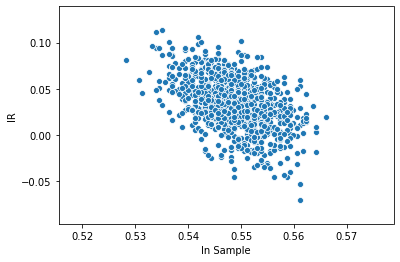

In [480]:
sns.scatterplot(y='IR',x='In Sample',data=final_res_hp)

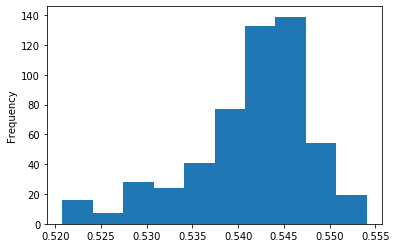

In [481]:
pd.Series(y_pred).plot(kind='hist')